# House Price Prediction

### Project Information:
#### Kaggle competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/
#### Author: Yifei (Faye) Liu
#### Date: Sep 2018

?? Put contents table here

1. **Understand the goal**. The goal for this project is predicting the house price which is a continuous variable. 
2. **Understand the inputs**. 
3. **Clean the data**. Handle missing values and transform the data into a more usable format.
3. **Train the model**. I will try out a few different models, including linear regression, etc. 
4. **Evaluate the model**. For each model trained, we will evaluate the model accuracy. 

Now, let's start diving into the data!

In [25]:
## load packages
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats

%matplotlib inline
warnings.filterwarnings('ignore')

## read data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print('training dataset has %d rows and %d columns' % df_train.shape)
print('test dataset dimension has %d rows and %d columns' % df_test.shape)

## set aside the sales price for training set
y_train = df_train.SalePrice

## append training and testing independent variables
X = df_train.iloc[:,0:80]
X = X.append(df_test.iloc[:,0:80])

## print out independent variable names and dimension of data
print('Variables are:')
print(list(X))

training dataset has 1460 rows and 81 columns
test dataset dimension has 1459 rows and 80 columns
Variables are:
['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCo

We also need to examine the missing values in X_train data and drop some of the columns that have too many missing values, or drop some cases that have too many missing values.

In [26]:
missing = pd.DataFrame({'is_null': df_test.isnull().any()})
missing = missing.loc[lambda df: df.is_null == True, :].index.tolist()

## drop the variables that have missing in testing dataset
X = X.drop(missing, axis = 1)

missing = pd.DataFrame({'is_null': X.isnull().any()})
missing = missing.loc[lambda df: df.is_null == True, :].index.tolist()

for var in missing:
	print(str(var))
	print(X[var].count())
    
## we could see that the missing in training dataset is not many. 
## fill the missing with mode
# X.groupby("Electrical").Id.count()
X.Electrical = X.Electrical.fillna("SBrkr")
X.info()

Electrical
2918
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 47 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
LotArea          2919 non-null int64
Street           2919 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
ExterQual        2919 non-null object
ExterCond        2919 non-null object
Foundation       2919 non-null object
Heating          2919 non-null object
HeatingQC 

Besides the "Id" variable and dependent variable "SalePrice", we have 46 variables can be used as model inputs. We could categorize all these variables into three type, "categorical", "numeric" and "date". Then let's see some basic descriptions about these variables.

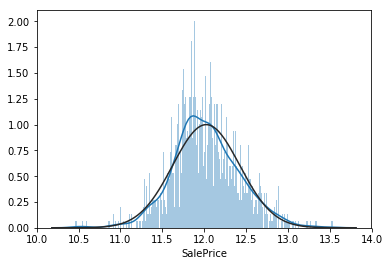

TypeError: unhashable type: 'slice'

In [24]:
## put these variables into three categories
date_l = ['YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold']

numeric_l = ['LotArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 
             'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

cat_l = ['MSSubClass', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
         'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'ExterQual', 
         'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FullBath', 'HalfBath', 
         'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'PavedDrive', 'SaleCondition']

# [item for item in date_l if item in list(X)]
# [item for item in numeric_l if item in list(X)]
# cat_l = [item for item in cat_l if item in c_l]

## create HouseAge and RemodAge
X['HouseAge'] = np.maximum(X['YrSold'] - X['YearBuilt'], np.zeros(X.shape[0]))
X['RemodAge'] = np.maximum(X['YrSold'] - X['YearRemodAdd'], np.zeros(X.shape[0]))

X = X.drop(date_l, axis = 1)

## convert all categorical variables into dummy variables
for var in cat_l:
	X[var] = X[var].astype('category')

## print(cat_l)
def freq(x):
    df_freq = pd.crosstab(x, columns = 'count')
    return df_freq

# for var in cat_l:
#     print(freq(X[var]))

# for var in numeric_l:
#     print(X[var].describe())

## plot a histgram
y = np.log1p(y_train)
sns.distplot(y, bins = 300, fit = stats.norm)
plt.show()

x = X.loc['GrLivArea']
sns.scatterplot(x.iloc[0:1460], y)
plt.show()

We will trian the regression model using inputs from X. Because there are 262 dummy variables and some variables don't even have much differentiation along the price change, i.e. the split between 0 and 1 are too extreme that it won't explain much differentiation in house price. Therefore, we are going to use some regularization method such as lasso regression to let algorithm to automatically select the important variables.

Root Mean Squared Error: 0.1250117058509143


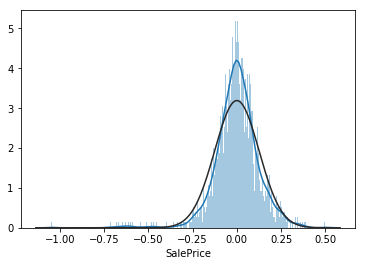

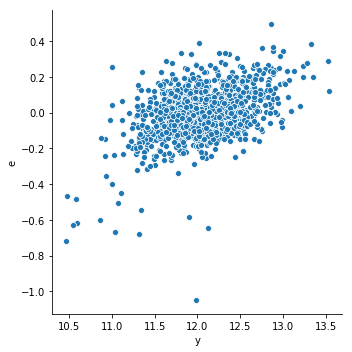

In [4]:
X1 = pd.get_dummies(X, drop_first = True)

X_train = X1.iloc[0:1460, :]
# X_train.shape
# (1459, 188)

X_test = X1.iloc[1460:2919, :]
# X_test.shape
# (1458, 188)

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

steps = [('scaler', StandardScaler()),
		('ridge', Ridge())]

pipeline = Pipeline(steps)

params = {'ridge__alpha': np.logspace(2, 3, 100)}

cv = GridSearchCV(pipeline, params, cv = 4)
cv.fit(X_train, y)
y_pred = cv.predict(X_train)
# rmse on the train dataset
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
# Root Mean Squared Error: 0.11721060569306577
## plot residual
e = y - y_pred
sns.distplot(e, bins = 300, fit = stats.norm)
plt.show()

diag = pd.DataFrame({
		"y" : y,
		"y_pred": y_pred,
		"e": e})

sns.relplot(x = 'y', y = 'e', data=diag)
plt.show()
## residual is pretty randomly scattered around(average price, 0) but still we could
## see a little bit of linear trend that goes from left bottom corner to right upper corner
## suspect it's because of the heavy tail of sales price. So of the extreme price would make regression 
## more heavily depend on those outliers. 

Root Mean Squared Error: 0.08421451202086681


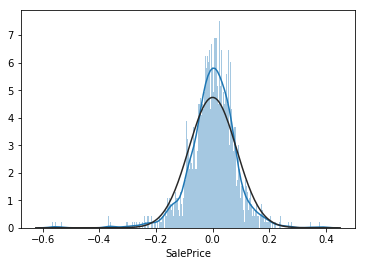

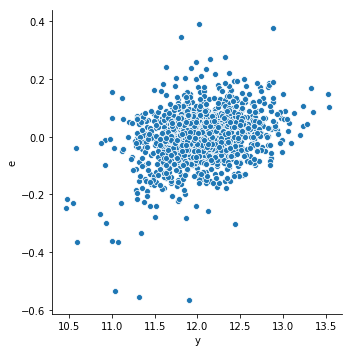

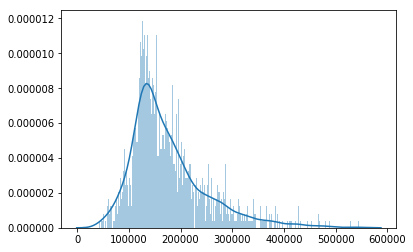

In [6]:
## gradient tree model
X2 = X.copy()
for var in cat_l:
	X2[var] = X2[var].cat.codes

X_train = X2.iloc[0:1460, :]
X_test = X2.iloc[1460:2919, :]

from sklearn.ensemble import GradientBoostingRegressor

params = {'gbreg__n_estimators': [1800,2000, 2200, 2400],
		  'gbreg__learning_rate': [0.01, 0.1]}

steps = [('scaler', StandardScaler()),
		('gbreg', GradientBoostingRegressor(min_samples_split=2,min_samples_leaf=10,max_features='auto',random_state=0,subsample = 0.8))]

pipeline = Pipeline(steps)

GBcv = GridSearchCV(pipeline, params, cv = 3, n_jobs = 3, scoring = 'neg_mean_squared_error', iid = False)
GBcv.fit(X_train, y)

GBcv.best_params_
# {'gbreg__learning_rate': 0.01, 'gbreg__n_estimators': 2200}
y_pred = GBcv.predict(X_train)

rmse = np.sqrt(mean_squared_error(y, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
# Root Mean Squared Error: 0.08421514340676496
e = y - y_pred
sns.distplot(e, bins = 300, fit = stats.norm)
plt.show()

diag = pd.DataFrame({
		"y" : y,
		"y_pred": y_pred,
		"e": e})

sns.relplot(x = 'y', y = 'e', data=diag)
plt.show()

yt_pred = GBcv.predict(X_test)
yt_pred = np.exp(yt_pred) - 1


sns.distplot(yt_pred, bins = 300)
plt.show()

prediction = pd.DataFrame({'Id': df_test.Id,
							'SalePrice': yt_pred})